In [2]:
from collections import Counter
from datetime import datetime

import numpy as np
import pandas as pd

import sklearn
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

% matplotlib inline
pd.set_option('display.max_columns', None)

In [9]:
FILE_PATH = "../"
FILE_NAME_DF = "01. Dataset/DandDang_review_book_cleaned.plk"
FILE_NAME_STAT_OUTPUT = "02. Stats/DandDang_review_book_stats.csv"

# FILE_NAME_1 = "01. Dataset/DangDang_review_book_P1.tsv"
# FILE_NAME_2 = "01. Dataset/DangDang_review_book_P2.tsv"

In [10]:
HEADERS = ["pid", "error_type", "comment_idx", "page", "username", "honor", "timestamp", "purchased", "support", "pic", "star", "comment1", "comment2"]

In [11]:
data_cleaned = pd.read_pickle(FILE_PATH + FILE_NAME_DF)

# 0. Clean Data

In [4]:
# Load Raw Data

data_raw = []
with open(FILE_PATH + FILE_NAME_1, "r") as f:
    for line in f:
        data_raw.append(line.strip("\n"))
with open(FILE_PATH + FILE_NAME_2, "r") as f:
    for line in f:
        data_raw.append(line.strip("\n"))

In [5]:
# Clean \t in the Reviews

for i in range(len(data_raw)):
    cur_record = data_raw[i].split("\t")
    data_raw[i] = cur_record[:11] + \
                 [" ".join(cur_record[11:-1])] + \
                 [cur_record[-1]]
## Check
cnt = 0
for record in data_raw:
    if len(record) != 13:
        cnt += 1 
print(cnt)

0


In [6]:
# Change Data Types

data_cleaned = pd.DataFrame(data_raw, columns=HEADERS)

data_cleaned.pid = data_cleaned.pid.astype(int)
data_cleaned.comment_idx = data_cleaned.comment_idx.astype(int)
data_cleaned.page = data_cleaned.page.astype(int)
data_cleaned.purchased = data_cleaned.purchased.astype(int)
data_cleaned.support = data_cleaned.support.astype(int)
data_cleaned.pic = data_cleaned.pic.astype(int)
data_cleaned.star = data_cleaned.star.apply(lambda x:float(x.strip('%'))/100)

In [147]:
# Save DataFrame

# data_cleaned.to_pickle(FILE_PATH + FILE_NAME_DF)

# 1. Calc Stats

In [109]:
data_cleaned.head()

,pid,error_type,comment_idx,page,username,honor,timestamp,purchased,support,pic,star,comment1,comment2
0,3288,3_2,1,1,白色栗子,黄金会员,2013-12-01 17:35:16,1,0,0,0.8,书皮和书业之间的连接处撕开了。因为着急用没有追究。,None
1,3288,3_2,2,1,无昵称用户,普通会员,2018-12-11 23:14:24,1,0,0,1.0,正版图书，值得收藏，很喜欢！,None
2,3288,3_2,3,1,无昵称用户,钻石会员,2018-11-26 20:00:22,1,0,0,1.0,书皮与中间部分脱落损坏,None
3,3288,3_2,4,1,无昵称用户,钻石会员,2018-10-24 15:56:02,1,0,0,1.0,很不错的书,None
4,3288,3_2,5,1,匿名用户,钻石会员,2018-09-15 18:45:57,1,0,2,0.4,书不错，但打开书就烂成这样,None


In [110]:
data_cleaned["honor"] = data_cleaned.honor.apply(lambda x:"NA会员" if x == "" else x)
data_cleaned["timestamp"] = pd.to_datetime(data_cleaned.timestamp)
data_cleaned["comment1_len"] = data_cleaned.comment1.apply(len)
data_cleaned["comment2_len"] = data_cleaned.comment2.apply(lambda x:len(x) if x != "None" else 0)

In [111]:
df_stats = data_cleaned[["pid"]].drop_duplicates().reset_index(drop=True)
len(df_stats)

95210

In [112]:
comment_count_per_pid = pd.DataFrame(data_cleaned.groupby(["pid"])["comment_idx"].count()).rename({"comment_idx": "comment_count"}, axis=1)

comment1_len_ave_per_pid = pd.DataFrame(data_cleaned.groupby("pid")["comment1_len"].mean()).rename({"comment1_len": "comment1_len_ave"}, axis=1)
comment2_len_ave_per_pid = pd.DataFrame(data_cleaned.groupby("pid")["comment2_len"].mean()).rename({"comment2_len": "comment2_len_ave"}, axis=1)

pic_ave_per_pid = pd.DataFrame(data_cleaned.groupby("pid")["pic"].mean()).rename({"pic": "pic_ave"}, axis=1)

honor_distribution_per_pid = pd.DataFrame(data_cleaned.groupby(["pid", "honor"])["comment_idx"].count())
honor_distribution_per_pid = honor_distribution_per_pid.reset_index().pivot(index="pid", columns="honor", values="comment_idx").fillna(0)

purchased_count_per_pid = pd.DataFrame(data_cleaned[data_cleaned["purchased"] == 1].groupby(["pid"])["purchased"].count())
purchased_percantage_per_pid = purchased_count_per_pid / comment_count_per_pid.rename({"comment_count": "purchased"}, axis=1)
purchased_percantage_per_pid = purchased_percantage_per_pid.fillna(0).rename({"purchased": "purchased_percentage"}, axis=1)

timestamp_first_comment_per_pid = pd.DataFrame(data_cleaned.groupby("pid")["timestamp"].min()).rename({"timestamp": "timestamp_first_comment"}, axis=1)

In [113]:
df_stats = df_stats.set_index("pid").join(comment_count_per_pid) \
                                    .join(comment1_len_ave_per_pid) \
                                    .join(comment2_len_ave_per_pid) \
                                    .join(pic_ave_per_pid) \
                                    .join(honor_distribution_per_pid) \
                                    .join(purchased_percantage_per_pid) \
                                    .join(timestamp_first_comment_per_pid)
df_stats.head()

,comment_count,comment1_len_ave,comment2_len_ave,pic_ave,NA会员,普通会员,白银会员,钻石会员,黄金会员,purchased_percentage,timestamp_first_comment
pid,,,,,,,,,,,
3288,71,11.126761,0.0,0.084507,0.0,33.0,0.0,34.0,4.0,1.0,2007-10-23 10:31:18
21599,18,23.111111,0.0,0.000000,0.0,12.0,3.0,3.0,0.0,1.0,2008-02-18 19:56:16
24255,14,180.142857,0.0,0.000000,0.0,12.0,0.0,2.0,0.0,1.0,2008-11-29 01:52:35
26833,8,24.000000,0.0,0.000000,0.0,6.0,1.0,1.0,0.0,1.0,2007-12-12 10:23:20
26834,34,137.852941,0.0,0.000000,0.0,17.0,2.0,14.0,1.0,1.0,2007-12-12 10:24:38


In [114]:
df_stats.describe()

,comment_count,comment1_len_ave,comment2_len_ave,pic_ave,NA会员,普通会员,白银会员,钻石会员,黄金会员,purchased_percentage
count,95210.000000,95210.000000,95210.000000,95210.000000,95210.000000,95210.000000,95210.000000,95210.000000,95210.000000,95210.000000
mean,47.730081,27.869340,0.395758,0.157036,0.075696,12.867104,4.549396,26.852978,3.384907,0.960941
std,55.124994,33.522904,3.323575,0.316228,1.195943,18.860100,7.007809,36.870727,5.307518,0.140652
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,14.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.990000
50%,23.000000,20.230769,0.000000,0.042328,0.000000,4.000000,2.000000,11.000000,1.000000,1.000000
75%,100.000000,31.280000,0.110000,0.200000,0.000000,18.000000,7.000000,42.000000,5.000000,1.000000
max,400.000000,1610.000000,185.000000,5.000000,82.000000,362.000000,222.000000,396.000000,158.000000,1.000000


In [124]:
data_merged = data_cleaned.merge(df_stats.reset_index(), how="left", on="pid")

In [125]:
data_merged["days_to_617"] = (data_merged.timestamp - datetime.strptime("17/06/2019", "%d/%m/%Y").date()).dt.days
data_merged["days_to_first_review"] = (data_merged.timestamp - data_merged.timestamp_first_comment).dt.days

days_to_617_ave_per_pid = pd.DataFrame(data_merged.groupby("pid")["days_to_617"].mean()).rename({"days_to_617": "days_to_617_ave"}, axis=1)
days_to_first_review_ave_per_pid = pd.DataFrame(data_merged.groupby("pid")["days_to_first_review"].mean()).rename({"days_to_first_review": "days_to_first_review_ave"}, axis=1)

df_stats = df_stats.join(days_to_617_ave_per_pid) \
                   .join(days_to_first_review_ave_per_pid)
df_stats.head()

The history saving thread hit an unexpected error (OperationalError('unable to open database file',)).History will not be written to the database.


,comment_count,comment1_len_ave,comment2_len_ave,pic_ave,NA会员,普通会员,白银会员,钻石会员,黄金会员,purchased_percentage,timestamp_first_comment,days_to_617_ave,days_to_first_review_ave
pid,,,,,,,,,,,,,
3288,71,11.126761,0.0,0.084507,0.0,33.0,0.0,34.0,4.0,1.0,2007-10-23 10:31:18,-1603.098592,2651.746479
21599,18,23.111111,0.0,0.000000,0.0,12.0,3.0,3.0,0.0,1.0,2008-02-18 19:56:16,-2812.055556,1324.166667
24255,14,180.142857,0.0,0.000000,0.0,12.0,0.0,2.0,0.0,1.0,2008-11-29 01:52:35,-3200.357143,651.642857
26833,8,24.000000,0.0,0.000000,0.0,6.0,1.0,1.0,0.0,1.0,2007-12-12 10:23:20,-3213.250000,991.500000
26834,34,137.852941,0.0,0.000000,0.0,17.0,2.0,14.0,1.0,1.0,2007-12-12 10:24:38,-2170.382353,2034.441176


In [126]:
data_merged["days_to_first_review_<10"] = data_merged.days_to_first_review < 10
data_merged["days_to_first_review_10-19"] = (data_merged.days_to_first_review >= 10) & (data_merged.days_to_first_review <= 19)
data_merged["days_to_first_review_20-29"] = (data_merged.days_to_first_review >= 20) & (data_merged.days_to_first_review <= 29)
data_merged["days_to_first_review_30-39"] = (data_merged.days_to_first_review >= 30) & (data_merged.days_to_first_review <= 39)
data_merged["days_to_first_review_40-49"] = (data_merged.days_to_first_review >= 40) & (data_merged.days_to_first_review <= 49)
data_merged["days_to_first_review_50-59"] = (data_merged.days_to_first_review >= 50) & (data_merged.days_to_first_review <= 59)
data_merged["days_to_first_review_>=60"] = data_merged.days_to_first_review >= 60

df_days_to_first_review = data_merged[["pid", \
                                       "days_to_first_review_<10", \
                                       "days_to_first_review_10-19", \
                                       "days_to_first_review_20-29", \
                                       "days_to_first_review_30-39", \
                                       "days_to_first_review_40-49", \
                                       "days_to_first_review_50-59", \
                                       "days_to_first_review_>=60"]]
df_days_to_first_review = pd.melt(df_days_to_first_review,
                                  id_vars=["pid"], value_vars=df_days_to_first_review.columns[1:],
                                  var_name="days_to_first_review_sections", value_name="value")\
                                  .groupby(["pid", "days_to_first_review_sections"])["value"].sum()\
                                  .reset_index().pivot(index="pid", columns="days_to_first_review_sections", values="value")
        
df_stats = df_stats.join(df_days_to_first_review)
df_stats.head()

In [129]:
len(df_stats)

95210

In [131]:
df_stats.to_csv(FILE_NAME_STAT_OUTPUT)

In [141]:
data_merged2 = data_cleaned.merge(df_stats.reset_index(), how="left", on="pid")

In [161]:
data_merged2.describe()

,pid,comment_idx,page,purchased,support,pic,star,comment1_len,comment2_len,comment_count,comment1_len_ave,comment2_len_ave,pic_ave,NA会员,普通会员,白银会员,钻石会员,黄金会员,purchased_percentage,days_to_617_ave,days_to_first_review_ave,days_to_first_review_10-19,days_to_first_review_20-29,days_to_first_review_30-39,days_to_first_review_40-49,days_to_first_review_50-59,days_to_first_review_<10,days_to_first_review_>=60
count,4.544381e+06,4.544381e+06,4.544381e+06,4.544381e+06,4.544381e+06,4.544381e+06,4.544381e+06,4.544381e+06,4.544381e+06,4.544381e+06,4.544381e+06,4.544381e+06,4.544381e+06,4.544381e+06,4.544381e+06,4.544381e+06,4.544381e+06,4.544381e+06,4.544381e+06,4.544381e+06,4.544381e+06,4.544381e+06,4.544381e+06,4.544381e+06,4.544381e+06,4.544381e+06,4.544381e+06,4.544381e+06
mean,7.972134e+07,4.108343e+01,4.573257e+00,9.648900e-01,2.112596e-01,1.963594e-01,9.681922e-01,3.577171e+01,3.341742e-01,1.113950e+02,3.577171e+01,3.341742e-01,1.963594e-01,1.982600e-01,2.698549e+01,1.070195e+01,6.538979e+01,8.119540e+00,9.648900e-01,-8.337043e+02,6.618087e+02,2.486918e+00,2.033154e+00,1.798278e+00,1.590750e+00,1.554158e+00,6.072858e+00,9.585891e+01
std,2.571265e+08,2.921194e+01,2.897057e+00,1.840577e-01,2.886487e+00,6.619067e-01,1.141638e-01,8.577643e+01,4.774806e+00,7.868022e+01,3.321439e+01,1.616015e+00,2.783061e-01,2.101496e+00,2.713869e+01,1.148764e+01,6.046062e+01,8.746442e+00,1.110750e-01,5.794270e+02,5.571432e+02,1.019312e+01,7.760285e+00,6.884539e+00,4.836731e+00,5.350358e+00,1.817324e+01,6.930887e+01
min,3.288000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-4.483000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,2.334108e+07,1.500000e+01,2.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,9.000000e+00,0.000000e+00,8.000000e+01,1.934000e+01,0.000000e+00,3.296703e-02,0.000000e+00,9.000000e+00,4.000000e+00,2.700000e+01,3.000000e+00,9.800000e-01,-1.108140e+03,2.463333e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,5.700000e+01
50%,2.390744e+07,3.600000e+01,4.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.100000e+01,0.000000e+00,1.000000e+02,2.679000e+01,6.000000e-02,1.200000e-01,0.000000e+00,2.000000e+01,8.000000e+00,5.200000e+01,6.000000e+00,1.000000e+00,-6.702000e+02,5.024167e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,9.500000e+01
75%,2.517382e+07,6.500000e+01,7.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,3.700000e+01,0.000000e+00,1.000000e+02,4.252000e+01,3.300000e-01,2.500000e-01,0.000000e+00,3.800000e+01,1.300000e+01,7.600000e+01,1.000000e+01,1.000000e+00,-3.991300e+02,9.245500e+02,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.000000e+00,9.900000e+01
max,1.499941e+09,1.000000e+02,1.000000e+01,1.000000e+00,1.377000e+03,6.000000e+00,1.000000e+00,3.535000e+03,5.650000e+02,4.000000e+02,1.610000e+03,1.850000e+02,5.000000e+00,8.200000e+01,3.620000e+02,2.220000e+02,3.960000e+02,1.580000e+02,1.000000e+00,-6.000000e+00,3.953710e+03,2.670000e+02,2.720000e+02,2.670000e+02,1.270000e+02,2.120000e+02,3.920000e+02,3.970000e+02


In [147]:
# Check
item_pid = 1483628495
df_stats.loc[item_pid]

comment_count                                   5
comment1_len_ave                              7.8
comment2_len_ave                                0
pic_ave                                         0
NA会员                                            0
普通会员                                            0
白银会员                                            1
钻石会员                                            4
黄金会员                                            0
purchased_percentage                          0.4
timestamp_first_comment       2018-06-14 20:32:36
days_to_617_ave                            -332.8
days_to_first_review_ave                     34.6
days_to_first_review_10-19                      1
days_to_first_review_20-29                      1
days_to_first_review_30-39                      0
days_to_first_review_40-49                      0
days_to_first_review_50-59                      1
days_to_first_review_<10                        1
days_to_first_review_>=60                       1


In [148]:
data_merged2[data_merged2["pid"] == item_pid].describe()

,pid,comment_idx,page,purchased,support,pic,star,comment1_len,comment2_len,comment_count,comment1_len_ave,comment2_len_ave,pic_ave,NA会员,普通会员,白银会员,钻石会员,黄金会员,purchased_percentage,days_to_617_ave,days_to_first_review_ave,days_to_first_review_10-19,days_to_first_review_20-29,days_to_first_review_30-39,days_to_first_review_40-49,days_to_first_review_50-59,days_to_first_review_<10,days_to_first_review_>=60
count,5.000000e+00,5.000000,5.0,5.000000,5.000000,5.0,5.00000,5.000000,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
mean,1.483628e+09,3.000000,1.0,0.400000,1.600000,0.0,0.64000,7.800000,0.0,5.0,7.8,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.4,-332.8,34.6,1.0,1.0,0.0,0.0,1.0,1.0,1.0
std,0.000000e+00,1.581139,0.0,0.547723,1.516575,0.0,0.49295,5.215362,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,1.483628e+09,1.000000,1.0,0.000000,0.000000,0.0,0.10000,5.000000,0.0,5.0,7.8,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.4,-332.8,34.6,1.0,1.0,0.0,0.0,1.0,1.0,1.0
25%,1.483628e+09,2.000000,1.0,0.000000,0.000000,0.0,0.10000,5.000000,0.0,5.0,7.8,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.4,-332.8,34.6,1.0,1.0,0.0,0.0,1.0,1.0,1.0
50%,1.483628e+09,3.000000,1.0,0.000000,2.000000,0.0,1.00000,5.000000,0.0,5.0,7.8,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.4,-332.8,34.6,1.0,1.0,0.0,0.0,1.0,1.0,1.0
75%,1.483628e+09,4.000000,1.0,1.000000,3.000000,0.0,1.00000,7.000000,0.0,5.0,7.8,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.4,-332.8,34.6,1.0,1.0,0.0,0.0,1.0,1.0,1.0
max,1.483628e+09,5.000000,1.0,1.000000,3.000000,0.0,1.00000,17.000000,0.0,5.0,7.8,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.4,-332.8,34.6,1.0,1.0,0.0,0.0,1.0,1.0,1.0


In [149]:
data_merged2[data_merged2["pid"] == item_pid]

,pid,error_type,comment_idx,page,username,honor,timestamp,purchased,support,pic,star,comment1,comment2,comment1_len,comment2_len,comment_count,comment1_len_ave,comment2_len_ave,pic_ave,NA会员,普通会员,白银会员,钻石会员,黄金会员,purchased_percentage,timestamp_first_comment,days_to_617_ave,days_to_first_review_ave,days_to_first_review_10-19,days_to_first_review_20-29,days_to_first_review_30-39,days_to_first_review_40-49,days_to_first_review_50-59,days_to_first_review_<10,days_to_first_review_>=60
4544305,1483628495,3_3,1,1,无昵称用户,钻石会员,2018-09-09 11:48:13,1,0,0,1.0,性价比高！,None,5,0,5,7.8,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.4,2018-06-14 20:32:36,-332.8,34.6,1.0,1.0,0.0,0.0,1.0,1.0,1.0
4544306,1483628495,3_3,2,1,cherrycf,钻石会员,2018-08-05 10:46:19,1,0,0,1.0,孩子喜欢看,None,5,0,5,7.8,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.4,2018-06-14 20:32:36,-332.8,34.6,1.0,1.0,0.0,0.0,1.0,1.0,1.0
4544307,1483628495,3_3,3,1,无昵称用户,白银会员,2018-07-08 16:46:13,0,2,0,0.1,假书！那个封面是命运编织者的谎言！,None,17,0,5,7.8,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.4,2018-06-14 20:32:36,-332.8,34.6,1.0,1.0,0.0,0.0,1.0,1.0,1.0
4544308,1483628495,3_3,4,1,无昵称用户,钻石会员,2018-06-27 20:44:58,0,3,0,0.1,假的，太假了！,None,7,0,5,7.8,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.4,2018-06-14 20:32:36,-332.8,34.6,1.0,1.0,0.0,0.0,1.0,1.0,1.0
4544309,1483628495,3_3,5,1,简单821973,钻石会员,2018-06-14 20:32:36,0,3,0,1.0,呃呃呃呃呃,None,5,0,5,7.8,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.4,2018-06-14 20:32:36,-332.8,34.6,1.0,1.0,0.0,0.0,1.0,1.0,1.0


In [150]:
# Check
item_pid = 61305
df_stats.loc[item_pid]

comment_count                                 100
comment1_len_ave                            47.94
comment2_len_ave                             0.32
pic_ave                                      0.23
NA会员                                            0
普通会员                                           16
白银会员                                           12
钻石会员                                           63
黄金会员                                            9
purchased_percentage                         0.98
timestamp_first_comment       2014-01-21 13:46:01
days_to_617_ave                           -917.68
days_to_first_review_ave                  1054.84
days_to_first_review_10-19                      0
days_to_first_review_20-29                      0
days_to_first_review_30-39                      0
days_to_first_review_40-49                      1
days_to_first_review_50-59                      1
days_to_first_review_<10                        1
days_to_first_review_>=60                      97


In [151]:
data_merged2[data_merged2["pid"] == item_pid].describe()

,pid,comment_idx,page,purchased,support,pic,star,comment1_len,comment2_len,comment_count,comment1_len_ave,comment2_len_ave,pic_ave,NA会员,普通会员,白银会员,钻石会员,黄金会员,purchased_percentage,days_to_617_ave,days_to_first_review_ave,days_to_first_review_10-19,days_to_first_review_20-29,days_to_first_review_30-39,days_to_first_review_40-49,days_to_first_review_50-59,days_to_first_review_<10,days_to_first_review_>=60
count,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000,100.000000,100.000000,100.0,1.000000e+02,1.000000e+02,1.000000e+02,100.0,100.0,100.0,100.0,100.0,1.000000e+02,1.000000e+02,1.000000e+02,100.0,100.0,100.0,100.0,100.0,100.0,100.0
mean,61305.0,50.500000,5.500000,0.980000,0.350000,0.230000,0.998,47.940000,0.320000,100.0,4.794000e+01,3.200000e-01,2.300000e-01,0.0,16.0,12.0,63.0,9.0,9.800000e-01,-9.176800e+02,1.054840e+03,0.0,0.0,0.0,1.0,1.0,1.0,97.0
std,0.0,29.011492,2.886751,0.140705,0.998737,0.583528,0.020,27.611965,2.269161,0.0,1.428245e-14,2.231632e-16,3.347448e-16,0.0,0.0,0.0,0.0,0.0,4.463264e-16,1.828153e-12,2.285191e-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,61305.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.800,22.000000,0.000000,100.0,4.794000e+01,3.200000e-01,2.300000e-01,0.0,16.0,12.0,63.0,9.0,9.800000e-01,-9.176800e+02,1.054840e+03,0.0,0.0,0.0,1.0,1.0,1.0,97.0
25%,61305.0,25.750000,3.000000,1.000000,0.000000,0.000000,1.000,28.000000,0.000000,100.0,4.794000e+01,3.200000e-01,2.300000e-01,0.0,16.0,12.0,63.0,9.0,9.800000e-01,-9.176800e+02,1.054840e+03,0.0,0.0,0.0,1.0,1.0,1.0,97.0
50%,61305.0,50.500000,5.500000,1.000000,0.000000,0.000000,1.000,39.000000,0.000000,100.0,4.794000e+01,3.200000e-01,2.300000e-01,0.0,16.0,12.0,63.0,9.0,9.800000e-01,-9.176800e+02,1.054840e+03,0.0,0.0,0.0,1.0,1.0,1.0,97.0
75%,61305.0,75.250000,8.000000,1.000000,0.000000,0.000000,1.000,56.000000,0.000000,100.0,4.794000e+01,3.200000e-01,2.300000e-01,0.0,16.0,12.0,63.0,9.0,9.800000e-01,-9.176800e+02,1.054840e+03,0.0,0.0,0.0,1.0,1.0,1.0,97.0
max,61305.0,100.000000,10.000000,1.000000,7.000000,2.000000,1.000,139.000000,18.000000,100.0,4.794000e+01,3.200000e-01,2.300000e-01,0.0,16.0,12.0,63.0,9.0,9.800000e-01,-9.176800e+02,1.054840e+03,0.0,0.0,0.0,1.0,1.0,1.0,97.0


In [160]:
sorted(list(data_merged2[data_merged2["pid"] == item_pid].timestamp))

[Timestamp('2014-01-21 13:46:01'),
 Timestamp('2014-03-04 18:59:19'),
 Timestamp('2014-03-17 13:45:51'),
 Timestamp('2014-05-02 07:21:19'),
 Timestamp('2014-06-12 15:32:32'),
 Timestamp('2014-06-12 15:35:44'),
 Timestamp('2014-07-10 12:37:13'),
 Timestamp('2014-09-11 10:23:48'),
 Timestamp('2014-10-11 15:22:43'),
 Timestamp('2015-03-19 21:27:19'),
 Timestamp('2015-03-29 10:55:29'),
 Timestamp('2015-04-01 19:06:14'),
 Timestamp('2015-04-03 09:28:49'),
 Timestamp('2015-05-10 06:34:48'),
 Timestamp('2015-05-19 21:58:23'),
 Timestamp('2015-05-29 15:17:11'),
 Timestamp('2015-06-02 06:13:38'),
 Timestamp('2015-06-21 09:26:18'),
 Timestamp('2015-07-26 16:04:15'),
 Timestamp('2015-07-27 20:34:14'),
 Timestamp('2015-10-21 08:56:23'),
 Timestamp('2015-11-04 15:14:14'),
 Timestamp('2015-12-20 19:09:30'),
 Timestamp('2015-12-21 18:08:23'),
 Timestamp('2016-01-09 10:56:19'),
 Timestamp('2016-01-19 10:43:45'),
 Timestamp('2016-01-26 14:03:50'),
 Timestamp('2016-03-01 09:07:28'),
 Timestamp('2016-04-

# 2. Data Summary (Not Item Specific)

In [150]:
le = LabelEncoder()
le.fit(data_cleaned.honor.unique())
print(le.classes_)
data_cleaned.honor = le.transform(data_cleaned.honor)

['' '普通会员' '白银会员' '钻石会员' '黄金会员']


In [151]:
data_cleaned.describe()

,pid,comment_idx,page,honor,purchased,support,pic,star,comment1_len,comment2_len
count,4.544381e+06,4.544381e+06,4.544381e+06,4.544381e+06,4.544381e+06,4.544381e+06,4.544381e+06,4.544381e+06,4.544381e+06,4.544381e+06
mean,7.972134e+07,4.108343e+01,4.573257e+00,2.431684e+00,9.648900e-01,2.112596e-01,1.963594e-01,9.681922e-01,3.577171e+01,3.341742e-01
std,2.571265e+08,2.921194e+01,2.897057e+00,9.673909e-01,1.840577e-01,2.886487e+00,6.619067e-01,1.141638e-01,8.577643e+01,4.774806e+00
min,3.288000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e-01,0.000000e+00,0.000000e+00
25%,2.334108e+07,1.500000e+01,2.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,9.000000e+00,0.000000e+00
50%,2.390744e+07,3.600000e+01,4.000000e+00,3.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.100000e+01,0.000000e+00
75%,2.517382e+07,6.500000e+01,7.000000e+00,3.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,3.700000e+01,0.000000e+00
max,1.499941e+09,1.000000e+02,1.000000e+01,4.000000e+00,1.000000e+00,1.377000e+03,6.000000e+00,1.000000e+00,3.535000e+03,5.650000e+02


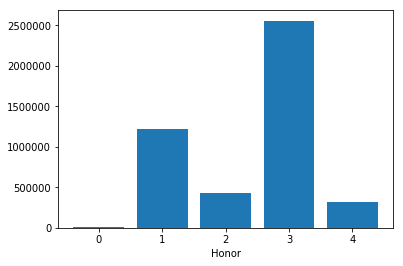

In [152]:
tmp = sorted(list(Counter(data_cleaned.honor).items()))
plt.bar([i[0] for i in tmp], [i[1] for i in tmp])
plt.xlabel('Honor')
plt.show()

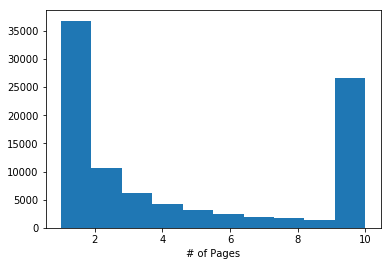

In [153]:
pages_per_item = pd.DataFrame(data_cleaned.groupby("pid")["page"].max())

plt.hist(pages_per_item.page)
plt.xlabel('# of Pages')
plt.show()

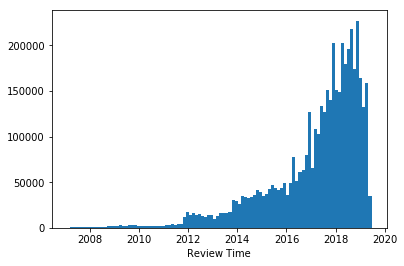

In [154]:
plt.hist(data_cleaned.timestamp, bins=100)
plt.xlabel('Review Time')
plt.show()

Purchased: 96.49%


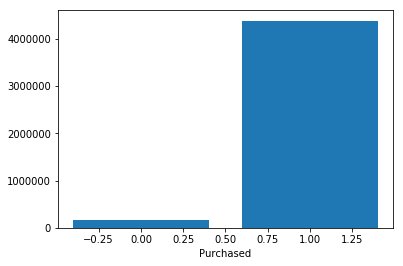

In [155]:
purchased_percentage = len(data_cleaned[data_cleaned["purchased"] == 1]) / len(data_cleaned) * 100
print("Purchased: {:.2f}%".format(purchased_percentage))

tmp = sorted(list(Counter(data_cleaned.purchased).items()))
plt.bar([i[0] for i in tmp], [i[1] for i in tmp])
plt.xlabel('Purchased')
plt.show()

Having Supports: 7.22%
1-100 Supports: 7.21%
>100 Supports: 0.01%


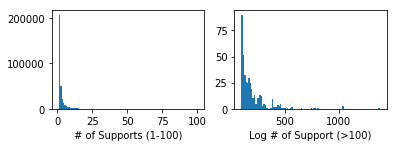

In [156]:
plt.figure(1)

support_percentage = len(data_cleaned[data_cleaned["support"] > 0]) / len(data_cleaned) * 100
print("Having Supports: {:.2f}%".format(support_percentage))

plt.subplot(221)
plt.hist(data_cleaned[(data_cleaned["support"] > 0) & (data_cleaned["support"] <= 100)].support, bins=100)
plt.xlabel('# of Supports (1-100)')

support_percentage = len(data_cleaned[(data_cleaned["support"] > 0) & (data_cleaned["support"] <= 100)]) / len(data_cleaned) * 100
print("1-100 Supports: {:.2f}%".format(support_percentage))

plt.subplot(222)
plt.hist(data_cleaned[data_cleaned["support"] > 100].support, bins=100)
plt.xlabel('Log # of Support (>100)')

support_percentage = len(data_cleaned[data_cleaned["support"] > 100]) / len(data_cleaned) * 100
print(">100 Supports: {:.2f}%".format(support_percentage))

plt.show()


Having Pictures: 11.36%


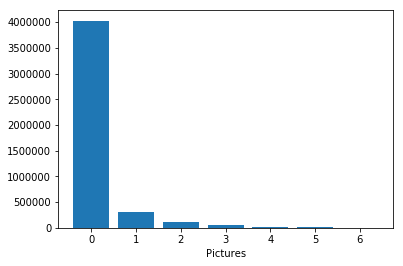

In [157]:
pic_percentage = len(data_cleaned[data_cleaned["pic"] > 0]) / len(data_cleaned) * 100
print("Having Pictures: {:.2f}%".format(pic_percentage))

tmp = sorted(list(Counter(data_cleaned.pic).items()))
plt.bar([i[0] for i in tmp], [i[1] for i in tmp])
plt.xlabel('Pictures')
plt.show()

Star = 1: 89.18%
Star >= 0.8: 96.03%


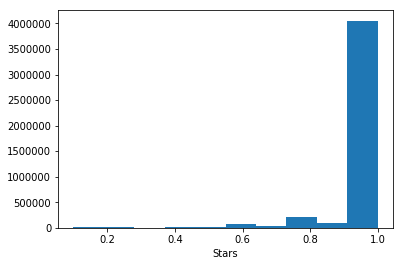

In [158]:
star_percentage = len(data_cleaned[data_cleaned["star"] == 1]) / len(data_cleaned) * 100
print("Star = 1: {:.2f}%".format(star_percentage))

star_percentage = len(data_cleaned[data_cleaned["star"] >= 0.8]) / len(data_cleaned) * 100
print("Star >= 0.8: {:.2f}%".format(star_percentage))

plt.hist(data_cleaned.star)
plt.xlabel('Stars')
plt.show()

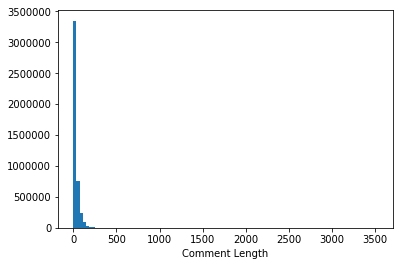

In [159]:
plt.hist(data_cleaned.comment1_len, bins=100)
plt.xlabel('Comment Length')
plt.show()

In [164]:
data_cleaned2 = data_cleaned.copy()
data_cleaned2["honor"] = le.inverse_transform(data_cleaned2.honor)

data_cleaned2.head()

/Users/meif/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


,pid,error_type,comment_idx,page,username,honor,timestamp,purchased,support,pic,star,comment1,comment2,comment1_len,comment2_len
0,3288,3_2,1,1,白色栗子,黄金会员,2013-12-01 17:35:16,1,0,0,0.8,书皮和书业之间的连接处撕开了。因为着急用没有追究。,None,25,0
1,3288,3_2,2,1,无昵称用户,普通会员,2018-12-11 23:14:24,1,0,0,1.0,正版图书，值得收藏，很喜欢！,None,14,0
2,3288,3_2,3,1,无昵称用户,钻石会员,2018-11-26 20:00:22,1,0,0,1.0,书皮与中间部分脱落损坏,None,11,0
3,3288,3_2,4,1,无昵称用户,钻石会员,2018-10-24 15:56:02,1,0,0,1.0,很不错的书,None,5,0
4,3288,3_2,5,1,匿名用户,钻石会员,2018-09-15 18:45:57,1,0,2,0.4,书不错，但打开书就烂成这样,None,13,0
